In [2]:
pip install summa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54388 sha256=6f4b92ac43c83fe5872a88f1b2e33dc14adf4bfde8efec75c90530c16236ba46
  Stored in directory: /root/.cache/pip/wheels/4a/ca/c5/4958614cfba88ed6ceb7cb5a849f9f89f9ac49971616bc919f
Successfully built summa


In [3]:
from importlib.metadata import version
import tensorflow
import summa
import pandas as pd
import numpy as np

print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

2.14.0
1.5.3
1.2.0


In [4]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [5]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [6]:
# 추출적 요약을 위해 데이터 프레임 복사
data_origin = data

In [7]:
data.sample(10)

,headlines,text
50621,I don't have the DNA for it: Oprah on US presi...,Dismissing speculations that she would be runn...
4731,68 IAS officers transferred by Rajasthan gover...,The newly elected Congress-led Rajasthan gover...
29214,IPL 2018's Purple Cap winner cost KXIP Ã¢ÂÂ¹3...,"Kings XI Punjab fast bowler Andrew Tye, who wa..."
18951,I donÃ¢ÂÂt want to hear it: Lata on recreati...,"Veteran singer Lata Mangeshkar, when asked abo..."
215,"Cancer survivor, living best life at 46: Lisa ...",nAfter a man commented 'too old' on 46-year-ol...
28714,Musk's OpenAI trains bots with 180 years of ga...,"Artificial intelligence startup OpenAI, co-fou..."
6615,Court rejects ex-Nissan Chairman's appeal to e...,A Tokyo court on Tuesday rejected ousted Nissa...
25482,12-yr-old who raped 8-yr-old girl molested 1-y...,"A 12-year-old boy, one of the five minors accu..."
49455,Thank you Baba: Deepika on Big B's letter for ...,Deepika Padukone took to social media to share...
90664,CBI arrests I-T commissioner for taking Ã¢ÂÂ¹...,The CBI on Wednesday arrested Income Tax Commi...


In [8]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [9]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [10]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [11]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [12]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [13]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    lemmatizer = WordNetLemmatizer() # 표제어 추출

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(lemmatizer.lemmatize(word) for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(lemmatizer.lemmatize(word) for word in sentence.split() if len(word) > 1)
    return tokens

In [14]:
clean_text = []

for text in data['text']:
    clean_text.append(preprocess_sentence(text))
# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr system engineer infosys almost year work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh career', 'kunal shah credit card bill payment platform cred gave user chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coin user get one cred coin per rupee bill paid used avail reward brand like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wicket fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victory dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customer enjoy tax benefit premium paid save tax plan provides life cover age year also customer option insure critical illness 

In [15]:
len(clean_text)

98360

import json

#### 리스트를 파일로 저장
with open('clean_text.json', 'w') as f:   
    json.dump(clean_text, f)


#### 저장 파일 읽어오기
with open('clean_text.json', 'r') as f:   
    clean_text_loaded_data = json.load(f)   

print(loaded_data)

In [16]:
clean_headlines = []

for text in data['headlines']:
    clean_headlines.append(preprocess_sentence(text))
# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_headlines[:5])

<ipython-input-13-cb1376a1c9e6>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거


Text 전처리 후 결과:  ['upgrad learner switch career ml al salary hike', 'delhi techie win free food swiggy one year cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan help customer save tax', 'known hirani yr metoo claim true sonam']



 #### 리스트를 파일로 저장
with open('clean_headlines.json', 'w') as f:   
    json.dump(clean_headlines, f)

#### 저장 파일 읽어오기

with open('clean_headlines.json', 'r') as f:   
    clean_headlines_loaded_data = json.load(f)

print(clean_headlines_loaded_data)

In [17]:
data.columns

Index(['headlines', 'text'], dtype='object')

In [18]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [19]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [20]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
텍스트의 3사분면 길이 : 38.0
텍스트의 3사분면 길이 : 33.0
5.0
요약의 최소 길이 : 1
요약의 최대 길이 : 13
요약의 평균 길이 : 7.136183407889386


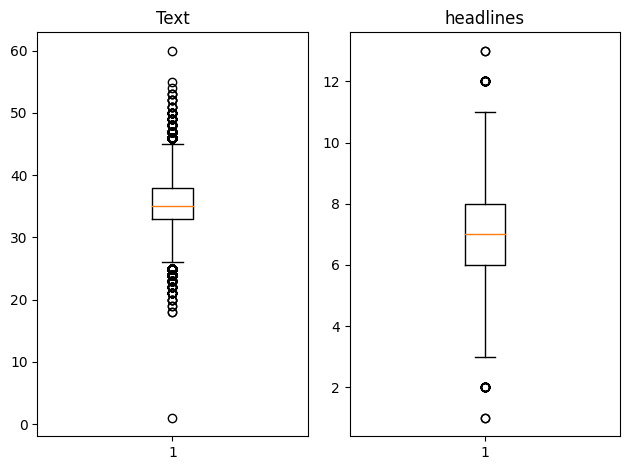

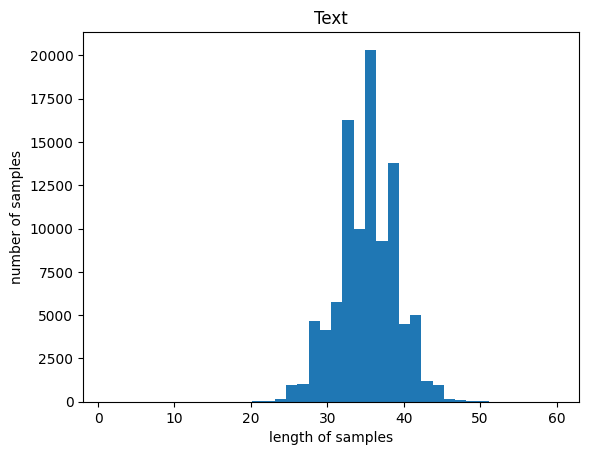

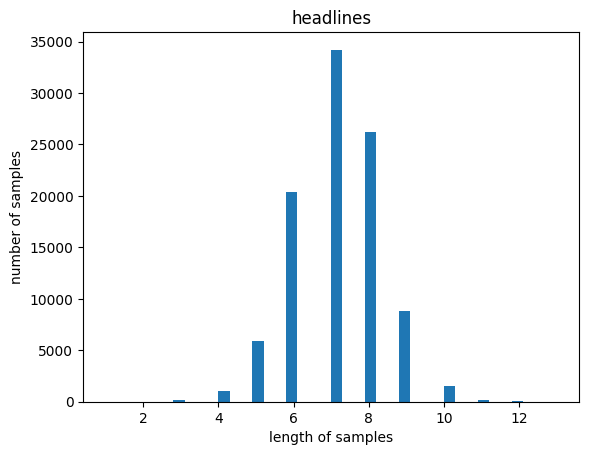

In [21]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('텍스트의 3사분면 길이 : {}'.format(np.percentile(text_len,75)))
print('텍스트의 3사분면 길이 : {}'.format(np.percentile(text_len,25)))
print((np.percentile(text_len,75))-(np.percentile(text_len,25)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [22]:
pip install plotly

In [23]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('텍스트의 3사분면 길이 : {}'.format(np.percentile(text_len,75)))
print('텍스트의 1사분면 길이 : {}'.format(np.percentile(text_len,25)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))
print('요약의 3사분면 길이 : {}'.format(np.percentile(headlines_len,75)))
print('요약의 1사분면 길이 : {}'.format(np.percentile(headlines_len,25)))

fig = make_subplots(rows=1, cols=2)

fig.add_trace(go.Box(y=text_len, name='Text'), row=1, col=1)
fig.add_trace(go.Box(y=headlines_len, name='Headlines'), row=1, col=2)

fig.update_layout(title_text="Text vs Headlines")
fig.show()

fig = go.Figure()
fig.add_trace(go.Histogram(x=text_len, nbinsx=40, name='Text'))
fig.update_layout(title_text="Text", xaxis_title="Length of samples", yaxis_title="Number of samples")
fig.show()

fig = go.Figure()
fig.add_trace(go.Histogram(x=headlines_len, nbinsx=40, name='Headlines'))
fig.update_layout(title_text="Headlines", xaxis_title="Length of samples", yaxis_title="Number of samples")
fig.show()


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
텍스트의 3사분면 길이 : 38.0
텍스트의 1사분면 길이 : 33.0
요약의 최소 길이 : 1
요약의 최대 길이 : 13
요약의 평균 길이 : 7.136183407889386
요약의 3사분면 길이 : 8.0
요약의 1사분면 길이 : 6.0


In [24]:
text_max_len = 42
headlines_max_len = 9

In [25]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [26]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 42 이하인 샘플의 비율: 0.9750305002033347
전체 샘플 중 길이가 9 이하인 샘플의 비율: 0.9826250508336722


In [27]:
data = data[data['text'].apply(lambda t: len(t.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda t: len(t.split()) <= headlines_max_len)]

print('전체 샘플수 :', (len(data)))


전체 샘플수 : 94367


In [28]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

<ipython-input-28-5f0b0a3a6e34>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-28-5f0b0a3a6e34>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,headlines,text,decoder_input,decoder_target
0,upgrad learner switch career ml al salary hike,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switch career ml al sa...,upgrad learner switch career ml al salary hike...
3,aegon life iterm insurance plan help customer ...,aegon life iterm insurance plan customer enjoy...,sostoken aegon life iterm insurance plan help ...,aegon life iterm insurance plan help customer ...
4,known hirani yr metoo claim true sonam,speaking sexual harassment allegation rajkumar...,sostoken known hirani yr metoo claim true sonam,known hirani yr metoo claim true sonam eostoken
5,rahat fateh ali khan denies getting notice smu...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice smu...
6,india get lowest odi total new zealand,india recorded lowest odi total new zealand ge...,sostoken india get lowest odi total new zealand,india get lowest odi total new zealand eostoken


In [29]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [30]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[37797 30277 77545 ... 37577 52609 11663]


In [31]:
# encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스 생성

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[42127 85844 73376 ... 30143 49093 89297]


In [32]:
#데이터의 샘플 순서를 다시 정의

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [33]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 18873


In [34]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 75494
훈련 레이블의 개수 : 75494
테스트 데이터의 개수 : 18873
테스트 레이블의 개수 : 18873


In [35]:
# 토크나이저 정의 후, 입력된 데이터로부터 단어 집합 생성
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

In [36]:
#등장 빈도수가 7회 미만인 단어들이 데이터에서 얼만큼의 비중을 차지하는지 확인

threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 61700
등장 빈도가 6번 이하인 희귀 단어의 수: 42408
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 19292
단어 집합에서 희귀 단어의 비율: 68.73257698541329
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.235404612848078


In [37]:
# 단어 집합의 크기를 제한 후 집합 재생성

src_vocab = 8000

src_tokenizer = Tokenizer(num_words=src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)

In [38]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[730, 104, 277, 4698, 2, 3732, 279, 2974, 6, 279, 1675, 2807, 181, 6908, 2165, 4931, 283, 2237, 2807], [675, 36, 536, 280, 540, 205, 25, 654, 276, 323, 208, 118, 391, 212, 2808, 905, 118, 2679, 165, 1495, 276, 675, 1150, 3202, 581, 1287], [3117, 94, 857, 156, 1220, 3045, 1193, 227, 620, 1040, 647, 4181, 141, 20, 681, 3045, 505, 141, 320, 3117, 5888, 2448, 320, 3045, 273, 845, 583, 141, 320, 2364, 1193]]


In [39]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [40]:
#등장 빈도수가 6회 미만인 단어들이 데이터에서 얼만큼의 비중을 차지하는지 확인

threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 25719
등장 빈도가 5번 이하인 희귀 단어의 수: 16755
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8964
단어 집합에서 희귀 단어의 비율: 65.14638982853144
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.242177024815904


In [41]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 260, 68, 12, 5], [1, 400, 917, 211, 205], [1, 224, 1896, 30, 74, 26], [1, 16, 109, 403, 1325, 174, 1787, 484], [1, 243, 22, 958, 3, 1326, 1509]]
target
decoder  [[260, 68, 12, 5, 2], [400, 917, 211, 205, 2], [224, 1896, 30, 74, 26, 2], [16, 109, 403, 1325, 174, 1787, 484, 2], [243, 22, 958, 3, 1326, 1509, 2]]


In [42]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 115
삭제할 테스트 데이터의 개수 : 37
훈련 데이터의 개수 : 75379
훈련 레이블의 개수 : 75379
테스트 데이터의 개수 : 18836
테스트 레이블의 개수 : 18836


In [43]:
# 패딩하기
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

In [44]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.3)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.3)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)


In [45]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [46]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 42)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 42, 128)              1024000   ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 42, 256),            394240    ['embedding[0][0]']           
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                              

In [47]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 42)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 42, 128)              1024000   ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 42, 256),            394240    ['embedding[0][0]']           
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                            

In [48]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
295/295 [==============================] - 43s 93ms/step - loss: 4.3677 - val_loss: 4.1335
Epoch 2/50
295/295 [==============================] - 20s 67ms/step - loss: 4.1058 - val_loss: 4.0155
Epoch 3/50
295/295 [==============================] - 19s 63ms/step - loss: 4.0015 - val_loss: 3.9272
Epoch 4/50
295/295 [==============================] - 21s 72ms/step - loss: 3.8717 - val_loss: 3.7815
Epoch 5/50
295/295 [==============================] - 18s 62ms/step - loss: 3.7332 - val_loss: 3.6441
Epoch 6/50
295/295 [==============================] - 18s 62ms/step - loss: 3.5820 - val_loss: 3.5275
Epoch 7/50
295/295 [==============================] - 19s 64ms/step - loss: 3.4841 - val_loss: 3.4465
Epoch 8/50
295/295 [==============================] - 19s 65ms/step - loss: 3.4097 - val_loss: 3.3926
Epoch 9/50
295/295 [==============================] - 19s 63ms/step - loss: 3.3427 - val_loss: 3.3761
Epoch 10/50
295/295 [==============================] - 19s 65ms/step - loss: 3.270

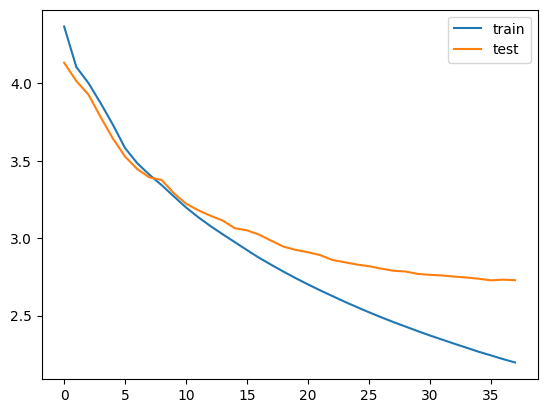

In [49]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [50]:
import plotly.graph_objects as go

# 데이터 생성
train_loss = go.Scatter(x=list(range(len(history.history['loss']))), y=history.history['loss'], mode='lines', name='train')
test_loss = go.Scatter(x=list(range(len(history.history['val_loss']))), y=history.history['val_loss'], mode='lines', name='test')

# 데이터를 합친 리스트 생성
data = [train_loss, test_loss]

# 레이아웃 생성
layout = go.Layout(autosize=False, width=500, height=500)

# 그래프 생성
fig = go.Figure(data=data, layout=layout)

# 그래프 출력
fig.show()

In [51]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [52]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


In [53]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [54]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [55]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0) and tar_index_to_word[i] != 'sostoken'and tar_index_to_word[i] != 'eostoken' :
            temp = temp + tar_index_to_word[i]+' '
    return temp

In [56]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : odisha government issued show cause notice school allegedly order extend summer vacation due heat wave notice said young child travel severe hot condition attend class asked principal open school june 
실제 요약 : odisha school get notice holiday 
1/1 [==============================] - 0s 19ms/step
예측 요약 :  mp govt order teacher


원문 : delhi patiala house court allowed congress mp shashi tharoor travel geneva switzerland meet former un secretary general mentor family tharoor sole accused death wife sunanda pushkar barred travelling abroad without prior permission also go un headquarters seek aid kerala flood 
실제 요약 : court allows tharoor visit family 
1/1 [==============================] - 0s 20ms/step
예측 요약 :  tharoor asks tharoor tharoor


원문 : addressing nation eve independence day president ram nath kovind said every citizen duty principle freedom struggle citing example farmer armed force among others added providing service freedom fellow citizen also spoke mahatma gandhi india 

### 추출적 요약 해보기

In [57]:
from summa.summarizer import summarize

In [58]:
url = "https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv"
df = pd.read_csv(url)


In [59]:
df.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [60]:
for i in range(50,100):
    print('Original : \n', df['text'][i])

    print("\nSummarized text: \n", (summarize(df['text'][i], ratio=0.5)), '\n\n')

Original : 
 Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth â¹31,000 crore by Dewan Housing Finance (DHFL). All agencies including regulators of the government have failed to track nefarious deals, he said. This comes after a media report on Tuesday accused DHFL's controlling shareholders of diverting funds to shell companies to buy assets.

Summarized text: 
 Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth â¹31,000 crore by Dewan Housing Finance (DHFL). 


Original : 
 US-based Boeing on Wednesday reported annual sales worth $101.12 billion in 2018, the first time the planemaker's sales crossed the $100-billion mark in its 102-year history. The company said it expects to deliver between 895 and 905 commercial aircraft in 2019. Boeing retained its position as the world's largest planemaker for the seventh straight year, delivering 806 aircraft in 2018. 

Summariz